# Конкурентное исключение в пространственной модели

Этот ноутбук демонстрирует принцип конкурентного исключения Гаузе в пространственной 2D модели. Два вида имеют **полностью идентичные параметры**:

- Одинаковая рождаемость и смертность
- Идентичная матрица конкуренции
- Равные радиусы распространения потомства и влияния конкуренции

В соответствии с экологическим принципом конкурентного исключения, два вида, занимающих одну и ту же экологическую нишу, не могут сосуществовать долгое время. Даже при абсолютно равных стартовых условиях, случайные флуктуации неизбежно приведут к доминированию одного вида и вымиранию другого.

Мы наблюдаем классический результат: один из видов вымирает, а другой выходит на стабильное плато численности. Для взаимодействий используются ядра с нормальным распределением.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sys
import os
from tqdm import tqdm
from scipy.stats import rayleigh
from matplotlib import animation
from matplotlib.animation import FuncAnimation

Смотрим на то, где находится корень проекта.

In [3]:
os.getcwd()

'/home/michael/SBDPP_sim/examples'

Указываем корень проекта.

In [ ]:
sys.path.append("/home/michael/SBDPP_sim") # ваш путь к папке с проектом
import simulation

In [5]:
M = 2          # Количество видов
my_seed = 42   # seed для генератора случайных чисел

Генерируем палитру с фиксированными цветами для M видов и создаем словарь: {вид: цвет}

In [6]:
colors = sns.color_palette("tab10", M)
color_dict = {i: colors[i] for i in range(M)}

Инициализируем все параметры и устанавливаем виды в начальные позиции.

In [7]:
L = 2.0                           # Размер области

birth_rates = [0.4, 0.4]          # Вероятность рождаемости
natural_death_rates = [0.2, 0.2]  # Вероятность естественной смерти
competition_matrix = [            # Матрица конкуренции
    0.001, 0.001,                 # Влияние вида 1 на вид 1 и на вид 2
    0.001, 0.001                  # Влияние вида 2 на вид 1 и на вид 2
]                               

sigma_m = [0.04, 0.04]            # Радиус распространения потомства
sigma_w = np.array([              # Радиус влияния конкуренции
    [0.04, 0.04],
    [0.04, 0.04],
])

def normal_2d_radial(r, sigma):
    return (1 / (2 * np.pi * sigma**2)) * np.exp(-r**2 / (2 * sigma**2))


q_values = np.arange(0, 1.0, 0.001)

birth_inverse_values = []
for i in range(M):
    inverse_vals = rayleigh.ppf(q_values, scale=sigma_m[i])
    birth_inverse_values.append(inverse_vals.tolist())

death_r_values = []
death_density_values = []

for i in range(M):
    r_values_row = []
    density_row = []
    
    for j in range(M):
        r_max = min(10 * sigma_w[i,j], L/2)
        r_vals = np.linspace(0, r_max, 500)
        
        density = normal_2d_radial(r_vals, sigma_w[i, j])
        
        r_values_row.append(r_vals.tolist())
        density_row.append(density.tolist())
    
    death_r_values.append(r_values_row)
    death_density_values.append(density_row)


max_sigma = max(max(sigma_m), np.max(sigma_w))
max_r = min(10 * max_sigma, L/2)

g2 = simulation.PyGrid2(
    M = M,
    areaLen = [L, L],
    cellCount = [50, 50],
    isPeriodic = False,
    birthRates = birth_rates,
    deathRates = natural_death_rates,
    ddMatrix = competition_matrix,
    birthX = [q_values.tolist()] * M,
    birthY = birth_inverse_values,
    deathX_ = death_r_values,
    deathY_ = death_density_values,
    cutoffs = [max_r] * (M * M),
    seed = my_seed,
    rtimeLimit = 7200.0
)

np.random.seed(my_seed)
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(500)]
    coordinates.append(group)

g2.placePopulation(coordinates)

Производим симуляцию.

In [8]:
data = []
for t in (pbar := tqdm(range(3000))):
    for c in range(g2.get_num_cells()):
        for n in range(M):
            coords = g2.get_cell_coords(c, n)
            for x, y in coords:
                data.append([t, x, y, n])
    g2.run_for(1)
    pbar.set_description(f"Population: {g2.total_population}, Progress")

df = pd.DataFrame(columns = ['time', 'x', 'y', 's'], data = data)
# display(df.set_index('time'))

  0%|          | 0/3000 [00:00<?, ?it/s]

Population: 510, Progress: 100%|██████████| 3000/3000 [00:33<00:00, 89.93it/s] 


Выводим график первых моментов.

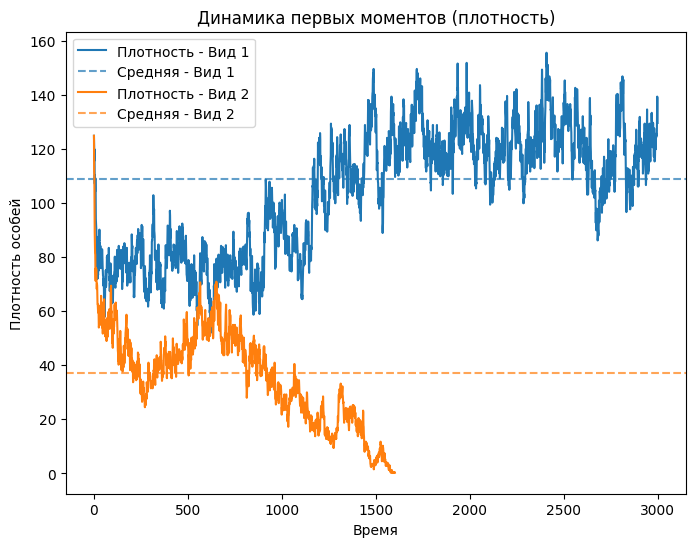

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

for n in range(M):
    density = df[df['s'] == n].groupby('time').size() / (L ** 2)  
    median_density = density.median()

    ax.plot(density.index, density.values, label=f'Плотность - Вид {n+1}', color=color_dict[n])
    ax.axhline(median_density, linestyle="dashed", color=color_dict[n], alpha=0.7, label=f'Средняя - Вид {n+1}')

ax.legend()
ax.set_xlabel("Время")
ax.set_ylabel("Плотность особей")
ax.set_title("Динамика первых моментов (плотность)")

plt.show()

По полученным данным создаем видео.

In [ ]:
total_frames = df['time'].nunique()
desired_duration = 120
fps = total_frames / desired_duration

movie_writer = animation.FFMpegWriter(
    fps=fps,
    codec = 'h264',
    bitrate = 2000,
    extra_args = [
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-preset', 'medium'
    ]
)

matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # путь к ffmpeg

df = df.sort_values('time')
output_file = "Random_Drift_Identical_Species_2min.mp4"

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c=[], s=20, alpha=0.6)

def update(frame):
    current_df = df[df['time'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_color([color_dict[s] for s in current_df['s']])
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['time'].nunique(), blit=True)
progress_callback = tqdm(total=total_frames, desc='Creating 1-minute video')

def on_frame(current_frame, *args):
    progress_callback.update(1)

ani.save(output_file, writer=movie_writer, progress_callback=on_frame)
progress_callback.close()

print(f"Animation saved as {output_file} (duration: 1 minute)")
plt.close(fig)

Creating 1-minute video:   1%|          | 37/3000 [00:15<02:51, 17.30it/s]